# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

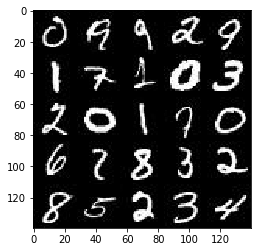

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

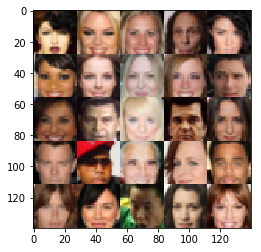

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z') 
    
    learn_rate = tf.placeholder(tf.float32, name='learning_rate')
  
    return inputs_real, inputs_z, learn_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [14]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):   
        
        x1 = tf.layers.conv2d(images, 64, 3, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        #x1 = tf.layers.conv2d(images, 64, 3, strides=2, padding='same', 
        #                      kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 3, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        #x2 = tf.layers.conv2d(x1, 128, 3, strides=2, padding='same', 
        #                      kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d(x2, 256, 3, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        #x3 = tf.layers.conv2d(x2, 256, 3, strides=2, padding='same', 
        #                      kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)

        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [16]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)

        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        #x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=2, 
        #      kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same')
        #x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 3, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        #x3 = tf.layers.conv2d_transpose(x2, 128, 3, strides=2, 
        #      kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same')
        #x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
       
        out = tf.tanh(logits) 
    
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [17]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [18]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [20]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    images_count, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt,  g_opt  = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batches in get_batches(batch_size):
                steps += 1
                
                # Because of tanh activation in generator function
                # Change the range from (-0.5, 0.5) to (-1, 1) to be consistent with batch_z
                # Seen in thread from forum for this project
                batches *= 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                # added learning_rate in dict
                _ = sess.run(d_opt, feed_dict={input_real: batches, input_z: batch_z, learn_rate: learning_rate})
                # generator runs twice to make sure that the discriminator loss does not go to zero.
                _ = sess.run(g_opt, feed_dict={input_real: batches, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batches, input_z: batch_z, learn_rate: learning_rate})

                if steps % 10 == 0:
                    # Get the losses and print them out after each 10 steps
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batches})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.7162... Generator Loss: 0.0441
Epoch 1/2... Discriminator Loss: 2.3574... Generator Loss: 0.2166
Epoch 1/2... Discriminator Loss: 1.4438... Generator Loss: 0.4760
Epoch 1/2... Discriminator Loss: 0.8263... Generator Loss: 1.1076
Epoch 1/2... Discriminator Loss: 2.1947... Generator Loss: 0.2252
Epoch 1/2... Discriminator Loss: 2.1222... Generator Loss: 0.3968
Epoch 1/2... Discriminator Loss: 2.2921... Generator Loss: 0.2468
Epoch 1/2... Discriminator Loss: 2.1478... Generator Loss: 0.3254
Epoch 1/2... Discriminator Loss: 2.2437... Generator Loss: 0.2422
Epoch 1/2... Discriminator Loss: 1.9776... Generator Loss: 0.4623


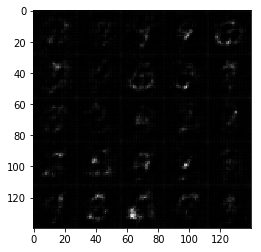

Epoch 1/2... Discriminator Loss: 2.1962... Generator Loss: 0.2498
Epoch 1/2... Discriminator Loss: 1.9088... Generator Loss: 0.3646
Epoch 1/2... Discriminator Loss: 1.8474... Generator Loss: 0.6500
Epoch 1/2... Discriminator Loss: 1.7257... Generator Loss: 0.3925
Epoch 1/2... Discriminator Loss: 1.7084... Generator Loss: 0.3993
Epoch 1/2... Discriminator Loss: 1.7414... Generator Loss: 0.4800
Epoch 1/2... Discriminator Loss: 1.5956... Generator Loss: 0.5678
Epoch 1/2... Discriminator Loss: 1.4990... Generator Loss: 0.8046
Epoch 1/2... Discriminator Loss: 1.5871... Generator Loss: 0.6156
Epoch 1/2... Discriminator Loss: 1.6924... Generator Loss: 0.3602


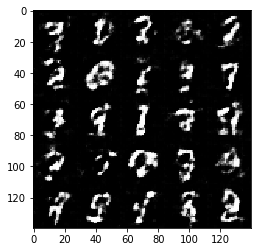

Epoch 1/2... Discriminator Loss: 1.4102... Generator Loss: 0.9359
Epoch 1/2... Discriminator Loss: 1.7807... Generator Loss: 0.3368
Epoch 1/2... Discriminator Loss: 1.4670... Generator Loss: 0.5984
Epoch 1/2... Discriminator Loss: 1.2577... Generator Loss: 0.7132
Epoch 1/2... Discriminator Loss: 1.5641... Generator Loss: 0.4400
Epoch 1/2... Discriminator Loss: 1.7249... Generator Loss: 0.4482
Epoch 1/2... Discriminator Loss: 1.7476... Generator Loss: 0.3950
Epoch 1/2... Discriminator Loss: 1.6692... Generator Loss: 0.5254
Epoch 1/2... Discriminator Loss: 1.6561... Generator Loss: 0.4083
Epoch 1/2... Discriminator Loss: 1.7977... Generator Loss: 1.0303


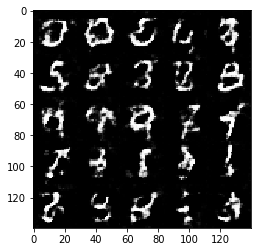

Epoch 1/2... Discriminator Loss: 1.7547... Generator Loss: 0.3617
Epoch 1/2... Discriminator Loss: 1.9762... Generator Loss: 0.2771
Epoch 1/2... Discriminator Loss: 1.6442... Generator Loss: 0.4493
Epoch 1/2... Discriminator Loss: 1.9996... Generator Loss: 0.2560
Epoch 1/2... Discriminator Loss: 1.6321... Generator Loss: 0.5004
Epoch 1/2... Discriminator Loss: 1.7200... Generator Loss: 0.4392
Epoch 1/2... Discriminator Loss: 1.7782... Generator Loss: 0.3617
Epoch 1/2... Discriminator Loss: 1.9307... Generator Loss: 0.2921
Epoch 1/2... Discriminator Loss: 1.5790... Generator Loss: 0.4638
Epoch 1/2... Discriminator Loss: 1.8113... Generator Loss: 0.3239


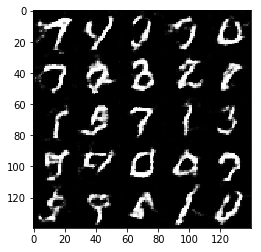

Epoch 1/2... Discriminator Loss: 1.7868... Generator Loss: 0.4787
Epoch 1/2... Discriminator Loss: 1.6242... Generator Loss: 0.4749
Epoch 1/2... Discriminator Loss: 1.5701... Generator Loss: 0.7115
Epoch 1/2... Discriminator Loss: 1.7298... Generator Loss: 0.3426
Epoch 1/2... Discriminator Loss: 1.6772... Generator Loss: 0.4967
Epoch 1/2... Discriminator Loss: 1.5506... Generator Loss: 0.5120
Epoch 1/2... Discriminator Loss: 1.6609... Generator Loss: 0.7214
Epoch 1/2... Discriminator Loss: 1.6967... Generator Loss: 0.4428
Epoch 1/2... Discriminator Loss: 1.7750... Generator Loss: 0.3501
Epoch 1/2... Discriminator Loss: 1.6538... Generator Loss: 0.4058


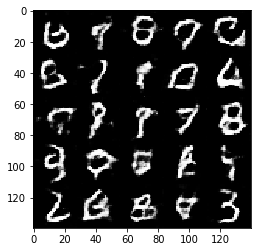

Epoch 1/2... Discriminator Loss: 1.7153... Generator Loss: 0.3768
Epoch 1/2... Discriminator Loss: 1.4270... Generator Loss: 0.6179
Epoch 1/2... Discriminator Loss: 1.5364... Generator Loss: 0.5740
Epoch 1/2... Discriminator Loss: 1.7270... Generator Loss: 0.4053
Epoch 1/2... Discriminator Loss: 1.5921... Generator Loss: 0.7043
Epoch 1/2... Discriminator Loss: 1.3663... Generator Loss: 0.7735
Epoch 1/2... Discriminator Loss: 1.4846... Generator Loss: 0.6321
Epoch 1/2... Discriminator Loss: 1.4120... Generator Loss: 0.7016
Epoch 1/2... Discriminator Loss: 1.4923... Generator Loss: 0.4998
Epoch 1/2... Discriminator Loss: 1.4512... Generator Loss: 0.8447


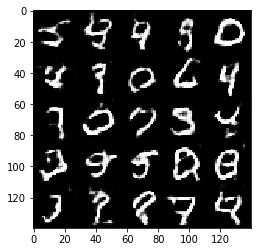

Epoch 1/2... Discriminator Loss: 1.6507... Generator Loss: 0.4042
Epoch 1/2... Discriminator Loss: 1.5241... Generator Loss: 0.6203
Epoch 1/2... Discriminator Loss: 1.3790... Generator Loss: 0.7187
Epoch 1/2... Discriminator Loss: 1.7456... Generator Loss: 0.3423
Epoch 1/2... Discriminator Loss: 1.8017... Generator Loss: 0.3341
Epoch 1/2... Discriminator Loss: 1.6577... Generator Loss: 0.3788
Epoch 1/2... Discriminator Loss: 1.6454... Generator Loss: 0.3788
Epoch 1/2... Discriminator Loss: 1.3489... Generator Loss: 1.0241
Epoch 1/2... Discriminator Loss: 1.5816... Generator Loss: 1.0041
Epoch 1/2... Discriminator Loss: 1.3258... Generator Loss: 0.5624


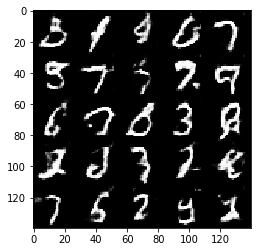

Epoch 1/2... Discriminator Loss: 1.3576... Generator Loss: 0.8160
Epoch 1/2... Discriminator Loss: 1.8403... Generator Loss: 0.2864
Epoch 1/2... Discriminator Loss: 1.2559... Generator Loss: 0.6854
Epoch 1/2... Discriminator Loss: 1.3488... Generator Loss: 0.6921
Epoch 1/2... Discriminator Loss: 1.2950... Generator Loss: 0.9596
Epoch 1/2... Discriminator Loss: 1.4840... Generator Loss: 0.5124
Epoch 1/2... Discriminator Loss: 1.3233... Generator Loss: 0.8322
Epoch 1/2... Discriminator Loss: 1.3617... Generator Loss: 0.5765
Epoch 1/2... Discriminator Loss: 1.8497... Generator Loss: 0.2854
Epoch 1/2... Discriminator Loss: 1.6660... Generator Loss: 0.4419


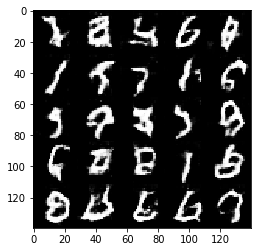

Epoch 1/2... Discriminator Loss: 1.4075... Generator Loss: 0.6017
Epoch 1/2... Discriminator Loss: 1.5232... Generator Loss: 0.5280
Epoch 1/2... Discriminator Loss: 1.1964... Generator Loss: 0.6951
Epoch 1/2... Discriminator Loss: 1.4208... Generator Loss: 0.5254
Epoch 1/2... Discriminator Loss: 1.3755... Generator Loss: 0.7664
Epoch 1/2... Discriminator Loss: 1.4454... Generator Loss: 0.6246
Epoch 1/2... Discriminator Loss: 1.7982... Generator Loss: 0.3199
Epoch 1/2... Discriminator Loss: 1.3555... Generator Loss: 0.6226
Epoch 1/2... Discriminator Loss: 1.9659... Generator Loss: 0.2438
Epoch 1/2... Discriminator Loss: 1.1718... Generator Loss: 1.1796


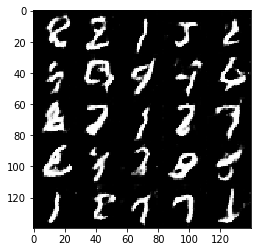

Epoch 1/2... Discriminator Loss: 1.6072... Generator Loss: 0.4764
Epoch 1/2... Discriminator Loss: 1.3581... Generator Loss: 0.7250
Epoch 1/2... Discriminator Loss: 1.5678... Generator Loss: 0.4309
Epoch 1/2... Discriminator Loss: 1.6815... Generator Loss: 0.3679
Epoch 1/2... Discriminator Loss: 1.4848... Generator Loss: 0.4681
Epoch 1/2... Discriminator Loss: 1.8206... Generator Loss: 0.2986
Epoch 1/2... Discriminator Loss: 1.3736... Generator Loss: 0.6195
Epoch 1/2... Discriminator Loss: 1.4104... Generator Loss: 0.8125
Epoch 1/2... Discriminator Loss: 1.5757... Generator Loss: 0.5354
Epoch 1/2... Discriminator Loss: 1.6028... Generator Loss: 0.3820


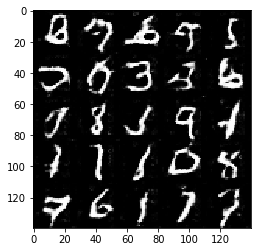

Epoch 1/2... Discriminator Loss: 1.4439... Generator Loss: 0.5624
Epoch 1/2... Discriminator Loss: 1.4109... Generator Loss: 0.5659
Epoch 1/2... Discriminator Loss: 1.6515... Generator Loss: 0.3538
Epoch 1/2... Discriminator Loss: 1.5483... Generator Loss: 0.4605
Epoch 1/2... Discriminator Loss: 1.3133... Generator Loss: 0.7012
Epoch 1/2... Discriminator Loss: 1.7466... Generator Loss: 0.3206
Epoch 1/2... Discriminator Loss: 1.5617... Generator Loss: 0.5756
Epoch 1/2... Discriminator Loss: 1.9077... Generator Loss: 0.4435
Epoch 1/2... Discriminator Loss: 1.6279... Generator Loss: 0.3821
Epoch 1/2... Discriminator Loss: 1.8655... Generator Loss: 0.2916


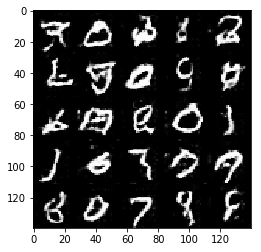

Epoch 1/2... Discriminator Loss: 1.3056... Generator Loss: 0.8436
Epoch 1/2... Discriminator Loss: 1.4733... Generator Loss: 0.4832
Epoch 1/2... Discriminator Loss: 1.4871... Generator Loss: 0.5390
Epoch 1/2... Discriminator Loss: 1.5386... Generator Loss: 0.4701
Epoch 1/2... Discriminator Loss: 1.4345... Generator Loss: 0.6387
Epoch 1/2... Discriminator Loss: 1.3715... Generator Loss: 0.5613
Epoch 1/2... Discriminator Loss: 1.6465... Generator Loss: 0.3558
Epoch 1/2... Discriminator Loss: 1.4566... Generator Loss: 0.4978
Epoch 1/2... Discriminator Loss: 1.2294... Generator Loss: 0.5917
Epoch 1/2... Discriminator Loss: 1.6488... Generator Loss: 0.3632


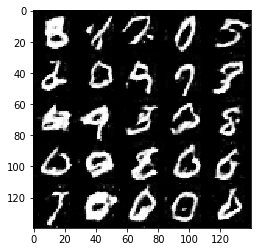

Epoch 1/2... Discriminator Loss: 1.4077... Generator Loss: 0.6700
Epoch 1/2... Discriminator Loss: 1.5426... Generator Loss: 0.4456
Epoch 1/2... Discriminator Loss: 1.4827... Generator Loss: 0.5250
Epoch 1/2... Discriminator Loss: 1.4754... Generator Loss: 0.4834
Epoch 1/2... Discriminator Loss: 1.4813... Generator Loss: 0.4362
Epoch 1/2... Discriminator Loss: 1.5480... Generator Loss: 0.5302
Epoch 1/2... Discriminator Loss: 1.6576... Generator Loss: 0.3662
Epoch 1/2... Discriminator Loss: 1.4661... Generator Loss: 0.5289
Epoch 1/2... Discriminator Loss: 1.7454... Generator Loss: 0.3089
Epoch 1/2... Discriminator Loss: 1.2940... Generator Loss: 0.6834


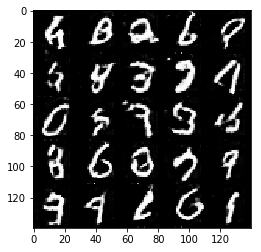

Epoch 1/2... Discriminator Loss: 1.3757... Generator Loss: 0.5331
Epoch 1/2... Discriminator Loss: 1.3610... Generator Loss: 0.5536
Epoch 1/2... Discriminator Loss: 1.4530... Generator Loss: 0.6948
Epoch 1/2... Discriminator Loss: 1.3917... Generator Loss: 0.5294
Epoch 1/2... Discriminator Loss: 1.4756... Generator Loss: 0.5359
Epoch 1/2... Discriminator Loss: 1.2956... Generator Loss: 0.7208
Epoch 1/2... Discriminator Loss: 1.5665... Generator Loss: 0.4999
Epoch 1/2... Discriminator Loss: 1.2598... Generator Loss: 0.6600
Epoch 1/2... Discriminator Loss: 1.5427... Generator Loss: 0.4514
Epoch 1/2... Discriminator Loss: 1.5264... Generator Loss: 0.4228


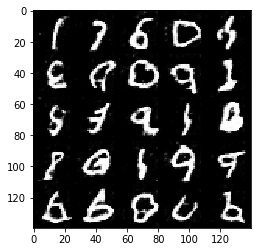

Epoch 1/2... Discriminator Loss: 1.3388... Generator Loss: 0.6535
Epoch 1/2... Discriminator Loss: 1.4267... Generator Loss: 0.4810
Epoch 1/2... Discriminator Loss: 1.4152... Generator Loss: 0.4759
Epoch 1/2... Discriminator Loss: 1.6302... Generator Loss: 0.4024
Epoch 1/2... Discriminator Loss: 1.3484... Generator Loss: 0.6707
Epoch 1/2... Discriminator Loss: 1.1505... Generator Loss: 0.8428
Epoch 1/2... Discriminator Loss: 1.3339... Generator Loss: 0.6562
Epoch 1/2... Discriminator Loss: 1.6744... Generator Loss: 0.3750
Epoch 1/2... Discriminator Loss: 1.3064... Generator Loss: 1.0332
Epoch 1/2... Discriminator Loss: 1.6037... Generator Loss: 0.5012


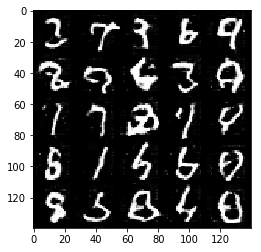

Epoch 1/2... Discriminator Loss: 1.3973... Generator Loss: 0.5792
Epoch 1/2... Discriminator Loss: 1.4528... Generator Loss: 0.8574
Epoch 1/2... Discriminator Loss: 1.1178... Generator Loss: 1.5442
Epoch 1/2... Discriminator Loss: 1.4425... Generator Loss: 0.6421
Epoch 1/2... Discriminator Loss: 1.9249... Generator Loss: 0.2581
Epoch 1/2... Discriminator Loss: 1.2021... Generator Loss: 0.6191
Epoch 1/2... Discriminator Loss: 1.1723... Generator Loss: 0.6919
Epoch 1/2... Discriminator Loss: 1.8296... Generator Loss: 1.2311
Epoch 1/2... Discriminator Loss: 1.4209... Generator Loss: 0.5709
Epoch 1/2... Discriminator Loss: 1.5490... Generator Loss: 0.6533


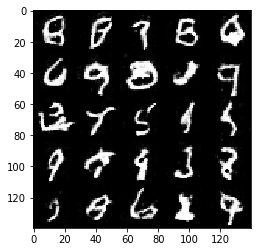

Epoch 1/2... Discriminator Loss: 1.6478... Generator Loss: 0.3902
Epoch 1/2... Discriminator Loss: 1.6483... Generator Loss: 0.3808
Epoch 1/2... Discriminator Loss: 1.2449... Generator Loss: 0.6910
Epoch 1/2... Discriminator Loss: 1.8185... Generator Loss: 0.3124
Epoch 1/2... Discriminator Loss: 1.7842... Generator Loss: 0.3109
Epoch 1/2... Discriminator Loss: 1.4064... Generator Loss: 0.5112
Epoch 1/2... Discriminator Loss: 1.6228... Generator Loss: 0.3728
Epoch 1/2... Discriminator Loss: 1.3473... Generator Loss: 0.9847
Epoch 1/2... Discriminator Loss: 1.3099... Generator Loss: 0.6215
Epoch 1/2... Discriminator Loss: 1.6893... Generator Loss: 0.3846


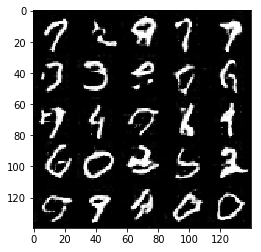

Epoch 1/2... Discriminator Loss: 1.5020... Generator Loss: 0.5828
Epoch 1/2... Discriminator Loss: 1.3798... Generator Loss: 0.5804
Epoch 1/2... Discriminator Loss: 1.8021... Generator Loss: 0.3216
Epoch 1/2... Discriminator Loss: 1.1947... Generator Loss: 1.1761
Epoch 1/2... Discriminator Loss: 1.4677... Generator Loss: 0.4466
Epoch 1/2... Discriminator Loss: 1.1664... Generator Loss: 0.8819
Epoch 1/2... Discriminator Loss: 1.0595... Generator Loss: 0.9129
Epoch 1/2... Discriminator Loss: 1.4715... Generator Loss: 0.5180
Epoch 1/2... Discriminator Loss: 1.3120... Generator Loss: 0.7363
Epoch 1/2... Discriminator Loss: 1.5833... Generator Loss: 0.3741


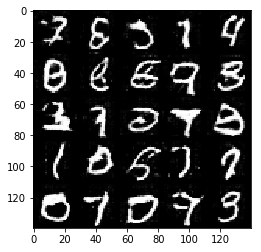

Epoch 1/2... Discriminator Loss: 1.2364... Generator Loss: 0.6447
Epoch 1/2... Discriminator Loss: 1.3740... Generator Loss: 0.5405
Epoch 1/2... Discriminator Loss: 1.2623... Generator Loss: 0.7595
Epoch 1/2... Discriminator Loss: 1.2995... Generator Loss: 0.6759
Epoch 1/2... Discriminator Loss: 1.4973... Generator Loss: 0.4134
Epoch 1/2... Discriminator Loss: 1.6412... Generator Loss: 0.3464
Epoch 1/2... Discriminator Loss: 1.3025... Generator Loss: 0.7483
Epoch 1/2... Discriminator Loss: 1.5645... Generator Loss: 0.4683
Epoch 1/2... Discriminator Loss: 1.2562... Generator Loss: 0.6696
Epoch 1/2... Discriminator Loss: 1.1793... Generator Loss: 0.7238


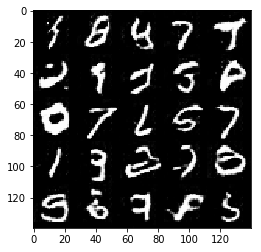

Epoch 1/2... Discriminator Loss: 1.8106... Generator Loss: 0.2969
Epoch 1/2... Discriminator Loss: 1.7440... Generator Loss: 0.4277
Epoch 1/2... Discriminator Loss: 1.6919... Generator Loss: 0.3962
Epoch 1/2... Discriminator Loss: 1.5486... Generator Loss: 0.4207
Epoch 1/2... Discriminator Loss: 1.5326... Generator Loss: 0.4539
Epoch 1/2... Discriminator Loss: 1.3603... Generator Loss: 0.5834
Epoch 1/2... Discriminator Loss: 1.1371... Generator Loss: 0.7561
Epoch 1/2... Discriminator Loss: 3.3695... Generator Loss: 0.0650
Epoch 1/2... Discriminator Loss: 1.3241... Generator Loss: 0.6088
Epoch 1/2... Discriminator Loss: 1.0971... Generator Loss: 0.7806


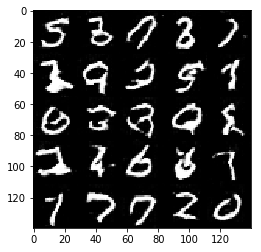

Epoch 2/2... Discriminator Loss: 0.9952... Generator Loss: 0.9616
Epoch 2/2... Discriminator Loss: 1.9705... Generator Loss: 0.3310
Epoch 2/2... Discriminator Loss: 1.5642... Generator Loss: 0.4366
Epoch 2/2... Discriminator Loss: 1.6400... Generator Loss: 0.3767
Epoch 2/2... Discriminator Loss: 1.4233... Generator Loss: 0.5389
Epoch 2/2... Discriminator Loss: 0.9814... Generator Loss: 0.9552
Epoch 2/2... Discriminator Loss: 1.5154... Generator Loss: 0.4742
Epoch 2/2... Discriminator Loss: 1.5359... Generator Loss: 0.3958
Epoch 2/2... Discriminator Loss: 1.3582... Generator Loss: 0.6538
Epoch 2/2... Discriminator Loss: 1.3408... Generator Loss: 0.8117


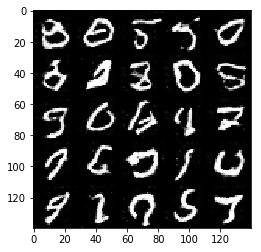

Epoch 2/2... Discriminator Loss: 1.4255... Generator Loss: 0.6040
Epoch 2/2... Discriminator Loss: 1.0579... Generator Loss: 0.8066
Epoch 2/2... Discriminator Loss: 1.4504... Generator Loss: 0.4744
Epoch 2/2... Discriminator Loss: 1.2730... Generator Loss: 0.6193
Epoch 2/2... Discriminator Loss: 1.3660... Generator Loss: 0.5282
Epoch 2/2... Discriminator Loss: 1.5835... Generator Loss: 0.3747
Epoch 2/2... Discriminator Loss: 1.5583... Generator Loss: 0.4186
Epoch 2/2... Discriminator Loss: 1.4458... Generator Loss: 0.5716
Epoch 2/2... Discriminator Loss: 1.1952... Generator Loss: 0.8976
Epoch 2/2... Discriminator Loss: 1.2090... Generator Loss: 0.9325


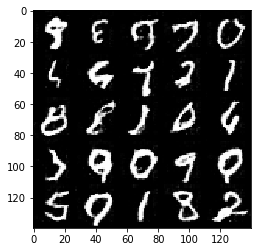

Epoch 2/2... Discriminator Loss: 1.2577... Generator Loss: 0.6456
Epoch 2/2... Discriminator Loss: 1.2827... Generator Loss: 0.6179
Epoch 2/2... Discriminator Loss: 1.2396... Generator Loss: 0.8243
Epoch 2/2... Discriminator Loss: 1.3915... Generator Loss: 0.5157
Epoch 2/2... Discriminator Loss: 0.9988... Generator Loss: 0.9510
Epoch 2/2... Discriminator Loss: 1.6685... Generator Loss: 0.3666
Epoch 2/2... Discriminator Loss: 1.3159... Generator Loss: 0.7056
Epoch 2/2... Discriminator Loss: 1.2461... Generator Loss: 0.6600
Epoch 2/2... Discriminator Loss: 1.4429... Generator Loss: 0.5138
Epoch 2/2... Discriminator Loss: 1.4391... Generator Loss: 0.4776


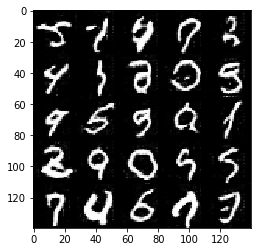

Epoch 2/2... Discriminator Loss: 1.2273... Generator Loss: 0.6917
Epoch 2/2... Discriminator Loss: 1.4305... Generator Loss: 0.4934
Epoch 2/2... Discriminator Loss: 1.3039... Generator Loss: 1.0869
Epoch 2/2... Discriminator Loss: 1.2547... Generator Loss: 0.6246
Epoch 2/2... Discriminator Loss: 1.1462... Generator Loss: 0.6898
Epoch 2/2... Discriminator Loss: 1.1085... Generator Loss: 0.7754
Epoch 2/2... Discriminator Loss: 1.5436... Generator Loss: 0.4535
Epoch 2/2... Discriminator Loss: 1.2266... Generator Loss: 0.7045
Epoch 2/2... Discriminator Loss: 1.5761... Generator Loss: 0.4197
Epoch 2/2... Discriminator Loss: 1.1177... Generator Loss: 0.8582


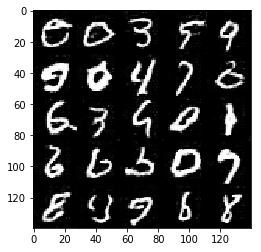

Epoch 2/2... Discriminator Loss: 1.2410... Generator Loss: 0.7052
Epoch 2/2... Discriminator Loss: 1.3580... Generator Loss: 0.5294
Epoch 2/2... Discriminator Loss: 1.3757... Generator Loss: 3.6247
Epoch 2/2... Discriminator Loss: 1.2379... Generator Loss: 0.6644
Epoch 2/2... Discriminator Loss: 1.2838... Generator Loss: 0.9067
Epoch 2/2... Discriminator Loss: 1.2861... Generator Loss: 0.8599
Epoch 2/2... Discriminator Loss: 1.0557... Generator Loss: 0.8598
Epoch 2/2... Discriminator Loss: 1.4079... Generator Loss: 0.5196
Epoch 2/2... Discriminator Loss: 1.5805... Generator Loss: 0.4491
Epoch 2/2... Discriminator Loss: 1.1037... Generator Loss: 0.7516


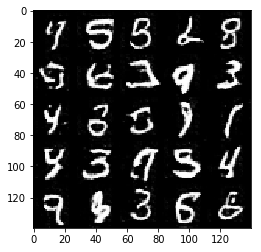

Epoch 2/2... Discriminator Loss: 1.1596... Generator Loss: 0.8629
Epoch 2/2... Discriminator Loss: 1.2325... Generator Loss: 0.6398
Epoch 2/2... Discriminator Loss: 1.0163... Generator Loss: 0.9070
Epoch 2/2... Discriminator Loss: 1.2514... Generator Loss: 0.6381
Epoch 2/2... Discriminator Loss: 1.5317... Generator Loss: 0.4367
Epoch 2/2... Discriminator Loss: 1.6754... Generator Loss: 0.3537
Epoch 2/2... Discriminator Loss: 1.3316... Generator Loss: 0.5866
Epoch 2/2... Discriminator Loss: 1.0650... Generator Loss: 1.0346
Epoch 2/2... Discriminator Loss: 1.1048... Generator Loss: 1.0885
Epoch 2/2... Discriminator Loss: 1.4940... Generator Loss: 0.5140


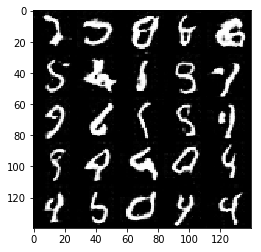

Epoch 2/2... Discriminator Loss: 1.6888... Generator Loss: 0.3664
Epoch 2/2... Discriminator Loss: 1.9611... Generator Loss: 0.2656
Epoch 2/2... Discriminator Loss: 0.6665... Generator Loss: 2.0199
Epoch 2/2... Discriminator Loss: 1.5614... Generator Loss: 0.4265
Epoch 2/2... Discriminator Loss: 1.5943... Generator Loss: 0.4791
Epoch 2/2... Discriminator Loss: 1.3551... Generator Loss: 0.6022
Epoch 2/2... Discriminator Loss: 1.5758... Generator Loss: 0.4155
Epoch 2/2... Discriminator Loss: 1.3912... Generator Loss: 0.5349
Epoch 2/2... Discriminator Loss: 1.1901... Generator Loss: 0.6731
Epoch 2/2... Discriminator Loss: 1.2702... Generator Loss: 0.7157


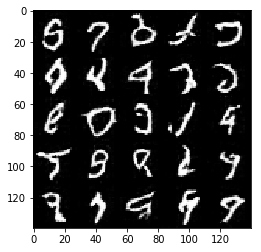

Epoch 2/2... Discriminator Loss: 1.5909... Generator Loss: 0.4187
Epoch 2/2... Discriminator Loss: 2.1499... Generator Loss: 0.2343
Epoch 2/2... Discriminator Loss: 1.2081... Generator Loss: 0.6779
Epoch 2/2... Discriminator Loss: 1.4748... Generator Loss: 0.4504
Epoch 2/2... Discriminator Loss: 1.0707... Generator Loss: 1.1945
Epoch 2/2... Discriminator Loss: 1.0940... Generator Loss: 0.7776
Epoch 2/2... Discriminator Loss: 1.1337... Generator Loss: 0.7472
Epoch 2/2... Discriminator Loss: 1.5148... Generator Loss: 0.4206
Epoch 2/2... Discriminator Loss: 1.1808... Generator Loss: 0.7009
Epoch 2/2... Discriminator Loss: 1.3279... Generator Loss: 0.5425


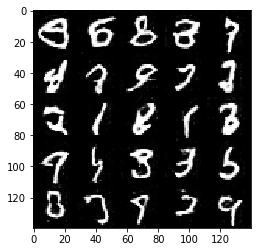

Epoch 2/2... Discriminator Loss: 1.1114... Generator Loss: 0.7756
Epoch 2/2... Discriminator Loss: 1.1765... Generator Loss: 0.7115
Epoch 2/2... Discriminator Loss: 1.0570... Generator Loss: 1.0916
Epoch 2/2... Discriminator Loss: 1.1213... Generator Loss: 0.8381
Epoch 2/2... Discriminator Loss: 1.3154... Generator Loss: 0.5691
Epoch 2/2... Discriminator Loss: 1.4459... Generator Loss: 0.4993
Epoch 2/2... Discriminator Loss: 1.2928... Generator Loss: 0.5764
Epoch 2/2... Discriminator Loss: 1.2785... Generator Loss: 0.6109
Epoch 2/2... Discriminator Loss: 1.6042... Generator Loss: 0.3725
Epoch 2/2... Discriminator Loss: 1.4981... Generator Loss: 0.4897


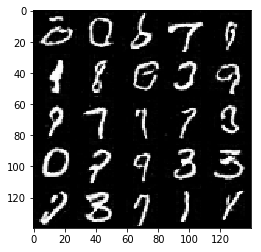

Epoch 2/2... Discriminator Loss: 1.3976... Generator Loss: 0.5035
Epoch 2/2... Discriminator Loss: 1.6042... Generator Loss: 0.4167
Epoch 2/2... Discriminator Loss: 1.5842... Generator Loss: 0.4080
Epoch 2/2... Discriminator Loss: 1.2079... Generator Loss: 0.7698
Epoch 2/2... Discriminator Loss: 1.4783... Generator Loss: 0.4374
Epoch 2/2... Discriminator Loss: 1.3707... Generator Loss: 0.5684
Epoch 2/2... Discriminator Loss: 1.3376... Generator Loss: 0.6031
Epoch 2/2... Discriminator Loss: 1.1229... Generator Loss: 0.8173
Epoch 2/2... Discriminator Loss: 1.0806... Generator Loss: 1.0822
Epoch 2/2... Discriminator Loss: 1.3783... Generator Loss: 0.5540


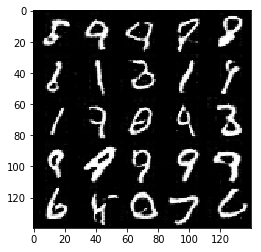

Epoch 2/2... Discriminator Loss: 1.1591... Generator Loss: 0.6935
Epoch 2/2... Discriminator Loss: 1.2391... Generator Loss: 0.7511
Epoch 2/2... Discriminator Loss: 1.2798... Generator Loss: 0.5835
Epoch 2/2... Discriminator Loss: 1.2580... Generator Loss: 0.7075
Epoch 2/2... Discriminator Loss: 1.1014... Generator Loss: 0.7475
Epoch 2/2... Discriminator Loss: 1.4937... Generator Loss: 0.4687
Epoch 2/2... Discriminator Loss: 1.7790... Generator Loss: 0.3397
Epoch 2/2... Discriminator Loss: 1.5050... Generator Loss: 0.4795
Epoch 2/2... Discriminator Loss: 1.3116... Generator Loss: 0.7350
Epoch 2/2... Discriminator Loss: 1.5328... Generator Loss: 0.4244


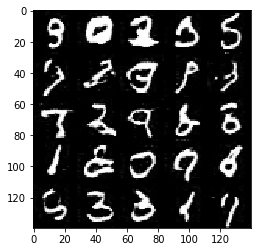

Epoch 2/2... Discriminator Loss: 1.4794... Generator Loss: 0.4799
Epoch 2/2... Discriminator Loss: 1.6284... Generator Loss: 0.4015
Epoch 2/2... Discriminator Loss: 1.0981... Generator Loss: 1.4468
Epoch 2/2... Discriminator Loss: 0.8707... Generator Loss: 1.1834
Epoch 2/2... Discriminator Loss: 1.6039... Generator Loss: 0.4268
Epoch 2/2... Discriminator Loss: 1.0593... Generator Loss: 1.0215
Epoch 2/2... Discriminator Loss: 1.5101... Generator Loss: 0.4591
Epoch 2/2... Discriminator Loss: 1.1464... Generator Loss: 0.7088
Epoch 2/2... Discriminator Loss: 1.0798... Generator Loss: 0.7971
Epoch 2/2... Discriminator Loss: 1.2677... Generator Loss: 0.6110


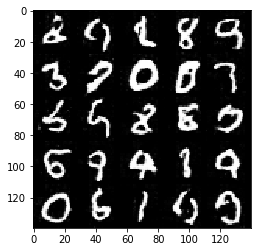

Epoch 2/2... Discriminator Loss: 0.8305... Generator Loss: 1.2181
Epoch 2/2... Discriminator Loss: 1.6722... Generator Loss: 0.4208
Epoch 2/2... Discriminator Loss: 1.0076... Generator Loss: 0.9415
Epoch 2/2... Discriminator Loss: 1.6631... Generator Loss: 0.3589
Epoch 2/2... Discriminator Loss: 1.3335... Generator Loss: 0.5322
Epoch 2/2... Discriminator Loss: 0.9886... Generator Loss: 0.8690
Epoch 2/2... Discriminator Loss: 1.7040... Generator Loss: 0.3565
Epoch 2/2... Discriminator Loss: 1.2156... Generator Loss: 0.6274
Epoch 2/2... Discriminator Loss: 1.2495... Generator Loss: 0.6243
Epoch 2/2... Discriminator Loss: 0.9612... Generator Loss: 1.0253


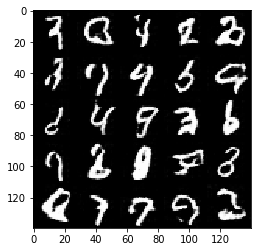

Epoch 2/2... Discriminator Loss: 1.2524... Generator Loss: 0.6627
Epoch 2/2... Discriminator Loss: 1.3475... Generator Loss: 0.5618
Epoch 2/2... Discriminator Loss: 1.1622... Generator Loss: 0.7602
Epoch 2/2... Discriminator Loss: 1.4216... Generator Loss: 0.5497
Epoch 2/2... Discriminator Loss: 1.8421... Generator Loss: 0.3121
Epoch 2/2... Discriminator Loss: 1.3674... Generator Loss: 0.5389
Epoch 2/2... Discriminator Loss: 1.3141... Generator Loss: 0.6077
Epoch 2/2... Discriminator Loss: 1.1575... Generator Loss: 0.8036
Epoch 2/2... Discriminator Loss: 1.0883... Generator Loss: 0.8578
Epoch 2/2... Discriminator Loss: 1.5385... Generator Loss: 0.4440


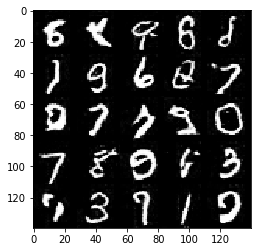

Epoch 2/2... Discriminator Loss: 1.1801... Generator Loss: 0.7229
Epoch 2/2... Discriminator Loss: 0.9525... Generator Loss: 0.9858
Epoch 2/2... Discriminator Loss: 1.5887... Generator Loss: 0.4128
Epoch 2/2... Discriminator Loss: 1.4598... Generator Loss: 0.4911
Epoch 2/2... Discriminator Loss: 1.4793... Generator Loss: 0.4843
Epoch 2/2... Discriminator Loss: 1.0913... Generator Loss: 0.9475
Epoch 2/2... Discriminator Loss: 0.9189... Generator Loss: 1.2715
Epoch 2/2... Discriminator Loss: 1.2888... Generator Loss: 0.6204
Epoch 2/2... Discriminator Loss: 1.1623... Generator Loss: 1.1631
Epoch 2/2... Discriminator Loss: 1.3103... Generator Loss: 0.8151


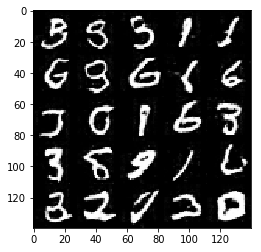

Epoch 2/2... Discriminator Loss: 1.2289... Generator Loss: 0.6774
Epoch 2/2... Discriminator Loss: 1.6971... Generator Loss: 0.3761
Epoch 2/2... Discriminator Loss: 1.2086... Generator Loss: 0.8770
Epoch 2/2... Discriminator Loss: 1.3472... Generator Loss: 0.7211
Epoch 2/2... Discriminator Loss: 1.4430... Generator Loss: 0.5090
Epoch 2/2... Discriminator Loss: 1.2912... Generator Loss: 0.6169
Epoch 2/2... Discriminator Loss: 0.9362... Generator Loss: 1.1350
Epoch 2/2... Discriminator Loss: 1.1534... Generator Loss: 0.7564
Epoch 2/2... Discriminator Loss: 1.2172... Generator Loss: 0.6524
Epoch 2/2... Discriminator Loss: 1.1620... Generator Loss: 0.8587


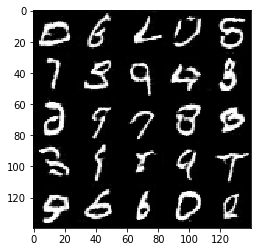

Epoch 2/2... Discriminator Loss: 1.1277... Generator Loss: 0.7773
Epoch 2/2... Discriminator Loss: 1.8323... Generator Loss: 0.3284
Epoch 2/2... Discriminator Loss: 1.0828... Generator Loss: 0.7768
Epoch 2/2... Discriminator Loss: 1.7051... Generator Loss: 0.3592
Epoch 2/2... Discriminator Loss: 1.2254... Generator Loss: 0.6354
Epoch 2/2... Discriminator Loss: 0.8497... Generator Loss: 1.0861
Epoch 2/2... Discriminator Loss: 1.3622... Generator Loss: 0.5090
Epoch 2/2... Discriminator Loss: 1.2531... Generator Loss: 0.6586
Epoch 2/2... Discriminator Loss: 1.3958... Generator Loss: 0.5175
Epoch 2/2... Discriminator Loss: 1.5086... Generator Loss: 0.4178


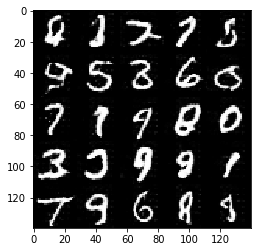

Epoch 2/2... Discriminator Loss: 1.8368... Generator Loss: 0.3121
Epoch 2/2... Discriminator Loss: 1.1492... Generator Loss: 0.7917
Epoch 2/2... Discriminator Loss: 1.3984... Generator Loss: 0.5411
Epoch 2/2... Discriminator Loss: 0.9586... Generator Loss: 1.0052
Epoch 2/2... Discriminator Loss: 1.2849... Generator Loss: 0.6495
Epoch 2/2... Discriminator Loss: 1.2202... Generator Loss: 0.6900
Epoch 2/2... Discriminator Loss: 1.2751... Generator Loss: 0.6617
Epoch 2/2... Discriminator Loss: 1.3412... Generator Loss: 0.6025
Epoch 2/2... Discriminator Loss: 1.3055... Generator Loss: 0.6211
Epoch 2/2... Discriminator Loss: 1.2887... Generator Loss: 0.7997


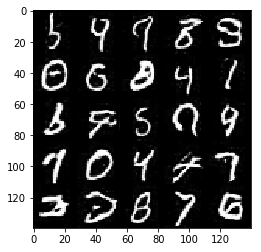

Epoch 2/2... Discriminator Loss: 0.9237... Generator Loss: 0.9514
Epoch 2/2... Discriminator Loss: 1.2214... Generator Loss: 0.6396
Epoch 2/2... Discriminator Loss: 1.1537... Generator Loss: 0.9466
Epoch 2/2... Discriminator Loss: 1.5851... Generator Loss: 0.4278
Epoch 2/2... Discriminator Loss: 1.3220... Generator Loss: 0.5627
Epoch 2/2... Discriminator Loss: 1.2331... Generator Loss: 0.6853
Epoch 2/2... Discriminator Loss: 1.4820... Generator Loss: 0.4767
Epoch 2/2... Discriminator Loss: 1.3489... Generator Loss: 0.5816
Epoch 2/2... Discriminator Loss: 1.4739... Generator Loss: 0.5051
Epoch 2/2... Discriminator Loss: 0.9503... Generator Loss: 1.0101


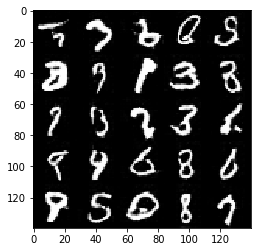

Epoch 2/2... Discriminator Loss: 1.6423... Generator Loss: 0.3672
Epoch 2/2... Discriminator Loss: 1.5198... Generator Loss: 0.4394
Epoch 2/2... Discriminator Loss: 0.8644... Generator Loss: 1.4923
Epoch 2/2... Discriminator Loss: 1.3100... Generator Loss: 0.6172
Epoch 2/2... Discriminator Loss: 1.0563... Generator Loss: 0.9883
Epoch 2/2... Discriminator Loss: 1.2348... Generator Loss: 0.9272
Epoch 2/2... Discriminator Loss: 1.1265... Generator Loss: 0.7949
Epoch 2/2... Discriminator Loss: 1.0841... Generator Loss: 0.8504
Epoch 2/2... Discriminator Loss: 1.1625... Generator Loss: 0.8277
Epoch 2/2... Discriminator Loss: 1.1237... Generator Loss: 0.9311


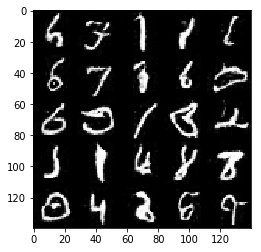

In [21]:
batch_size = 30
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 5.0169... Generator Loss: 0.0158
Epoch 1/1... Discriminator Loss: 4.0603... Generator Loss: 0.0362
Epoch 1/1... Discriminator Loss: 3.6846... Generator Loss: 0.0774
Epoch 1/1... Discriminator Loss: 3.5596... Generator Loss: 0.0510
Epoch 1/1... Discriminator Loss: 2.8093... Generator Loss: 0.1012
Epoch 1/1... Discriminator Loss: 3.0694... Generator Loss: 0.1165
Epoch 1/1... Discriminator Loss: 2.7406... Generator Loss: 0.1658
Epoch 1/1... Discriminator Loss: 2.7990... Generator Loss: 0.1884
Epoch 1/1... Discriminator Loss: 2.4753... Generator Loss: 0.2320
Epoch 1/1... Discriminator Loss: 2.5093... Generator Loss: 0.1985


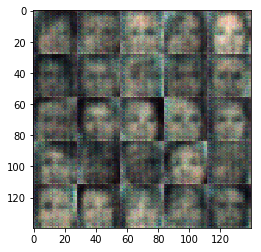

Epoch 1/1... Discriminator Loss: 2.1398... Generator Loss: 0.3960
Epoch 1/1... Discriminator Loss: 2.1035... Generator Loss: 0.3121
Epoch 1/1... Discriminator Loss: 2.3658... Generator Loss: 0.3262
Epoch 1/1... Discriminator Loss: 2.0699... Generator Loss: 0.3200
Epoch 1/1... Discriminator Loss: 1.5450... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 2.0453... Generator Loss: 0.3266
Epoch 1/1... Discriminator Loss: 1.7792... Generator Loss: 0.5165
Epoch 1/1... Discriminator Loss: 1.7961... Generator Loss: 0.5036
Epoch 1/1... Discriminator Loss: 1.7979... Generator Loss: 0.4523
Epoch 1/1... Discriminator Loss: 1.5720... Generator Loss: 0.6952


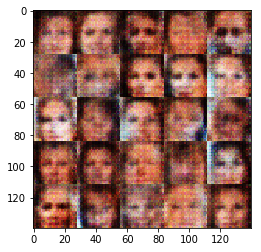

Epoch 1/1... Discriminator Loss: 1.7952... Generator Loss: 0.3937
Epoch 1/1... Discriminator Loss: 1.9677... Generator Loss: 0.3698
Epoch 1/1... Discriminator Loss: 2.0269... Generator Loss: 0.4264
Epoch 1/1... Discriminator Loss: 1.7660... Generator Loss: 0.4852
Epoch 1/1... Discriminator Loss: 1.9029... Generator Loss: 0.4917
Epoch 1/1... Discriminator Loss: 1.9518... Generator Loss: 0.4463
Epoch 1/1... Discriminator Loss: 1.9394... Generator Loss: 0.4406
Epoch 1/1... Discriminator Loss: 1.8818... Generator Loss: 0.4330
Epoch 1/1... Discriminator Loss: 1.8389... Generator Loss: 0.5048
Epoch 1/1... Discriminator Loss: 1.7406... Generator Loss: 0.5126


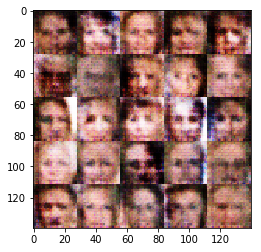

Epoch 1/1... Discriminator Loss: 1.7989... Generator Loss: 0.4847
Epoch 1/1... Discriminator Loss: 1.6763... Generator Loss: 0.5181
Epoch 1/1... Discriminator Loss: 1.6854... Generator Loss: 0.5353
Epoch 1/1... Discriminator Loss: 1.7677... Generator Loss: 0.5135
Epoch 1/1... Discriminator Loss: 1.7643... Generator Loss: 0.4855
Epoch 1/1... Discriminator Loss: 1.6270... Generator Loss: 0.5544
Epoch 1/1... Discriminator Loss: 1.6567... Generator Loss: 0.5395
Epoch 1/1... Discriminator Loss: 1.5885... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 1.7424... Generator Loss: 0.6039
Epoch 1/1... Discriminator Loss: 1.6073... Generator Loss: 0.5953


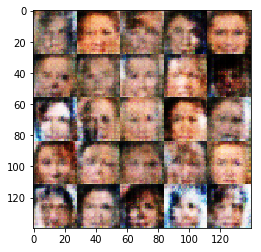

Epoch 1/1... Discriminator Loss: 1.6352... Generator Loss: 0.5894
Epoch 1/1... Discriminator Loss: 1.6567... Generator Loss: 0.5952
Epoch 1/1... Discriminator Loss: 1.5705... Generator Loss: 0.6326
Epoch 1/1... Discriminator Loss: 1.5557... Generator Loss: 0.6011
Epoch 1/1... Discriminator Loss: 1.6235... Generator Loss: 0.5874
Epoch 1/1... Discriminator Loss: 1.5084... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 1.5967... Generator Loss: 0.5974
Epoch 1/1... Discriminator Loss: 1.5672... Generator Loss: 0.6059
Epoch 1/1... Discriminator Loss: 1.5402... Generator Loss: 0.6559
Epoch 1/1... Discriminator Loss: 1.5108... Generator Loss: 0.6346


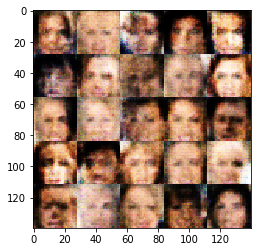

Epoch 1/1... Discriminator Loss: 1.5639... Generator Loss: 0.5995
Epoch 1/1... Discriminator Loss: 1.5323... Generator Loss: 0.6435
Epoch 1/1... Discriminator Loss: 1.5264... Generator Loss: 0.7139
Epoch 1/1... Discriminator Loss: 1.5002... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 1.5055... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.6341... Generator Loss: 0.6162
Epoch 1/1... Discriminator Loss: 1.5131... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.5830... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.5651... Generator Loss: 0.6671
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.6703


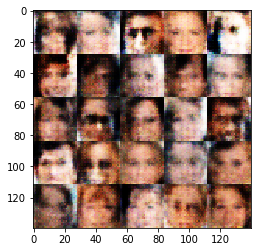

Epoch 1/1... Discriminator Loss: 1.5732... Generator Loss: 0.6312
Epoch 1/1... Discriminator Loss: 1.5149... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.5585... Generator Loss: 0.5902
Epoch 1/1... Discriminator Loss: 1.4873... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.5929... Generator Loss: 0.6546
Epoch 1/1... Discriminator Loss: 1.6715... Generator Loss: 0.5629
Epoch 1/1... Discriminator Loss: 1.4959... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 1.5099... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 1.5170... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.5102... Generator Loss: 0.6597


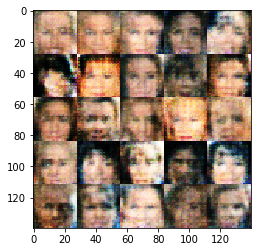

Epoch 1/1... Discriminator Loss: 1.4918... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.5195... Generator Loss: 0.6418
Epoch 1/1... Discriminator Loss: 1.5664... Generator Loss: 0.6585
Epoch 1/1... Discriminator Loss: 1.5131... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.5373... Generator Loss: 0.6760
Epoch 1/1... Discriminator Loss: 1.5487... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.4834... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.5021... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.5713... Generator Loss: 0.6408
Epoch 1/1... Discriminator Loss: 1.5432... Generator Loss: 0.6654


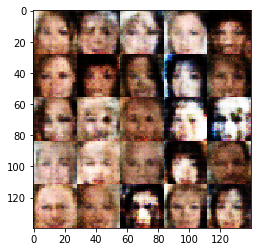

Epoch 1/1... Discriminator Loss: 1.5397... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.5339... Generator Loss: 0.6680
Epoch 1/1... Discriminator Loss: 1.4879... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.5858... Generator Loss: 0.6329
Epoch 1/1... Discriminator Loss: 1.4944... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.5447... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.5426... Generator Loss: 0.6203
Epoch 1/1... Discriminator Loss: 1.5296... Generator Loss: 0.6593


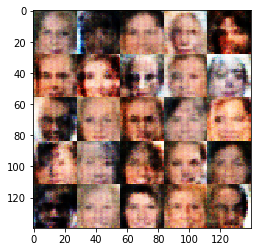

Epoch 1/1... Discriminator Loss: 1.5510... Generator Loss: 0.6255
Epoch 1/1... Discriminator Loss: 1.5150... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.5006... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.5483... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.5415... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 1.5028... Generator Loss: 0.6079
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.6646... Generator Loss: 0.6098
Epoch 1/1... Discriminator Loss: 1.5683... Generator Loss: 0.6684


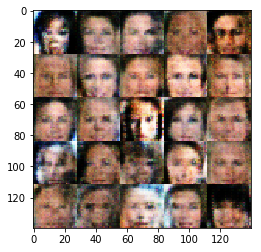

Epoch 1/1... Discriminator Loss: 1.5146... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.4804... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.4852... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.5341... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.5203... Generator Loss: 0.6889
Epoch 1/1... Discriminator Loss: 1.5316... Generator Loss: 0.6494
Epoch 1/1... Discriminator Loss: 1.4942... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.4768... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.5362... Generator Loss: 0.6003


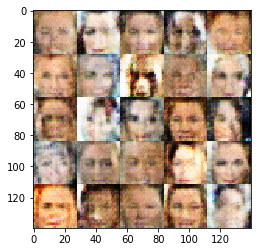

Epoch 1/1... Discriminator Loss: 1.4769... Generator Loss: 0.7047
Epoch 1/1... Discriminator Loss: 1.5759... Generator Loss: 0.6600
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.5160... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.4810... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.5067... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 1.6199... Generator Loss: 0.6378


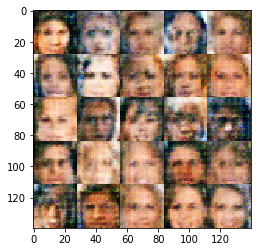

Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.5708... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 1.5499... Generator Loss: 0.7087
Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.4926... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 1.4637... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.4982... Generator Loss: 0.7236


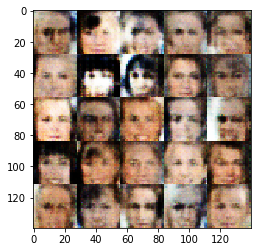

Epoch 1/1... Discriminator Loss: 1.4958... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 1.5318... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.5192... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.7378
Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.4913... Generator Loss: 0.7085


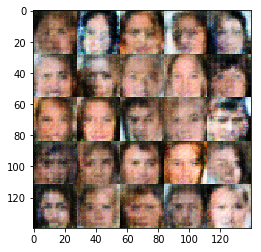

Epoch 1/1... Discriminator Loss: 1.5237... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 1.4955... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.4763... Generator Loss: 0.7292
Epoch 1/1... Discriminator Loss: 1.4847... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.4822... Generator Loss: 0.6453
Epoch 1/1... Discriminator Loss: 1.4911... Generator Loss: 0.6537
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 1.4887... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 1.5731... Generator Loss: 0.6402


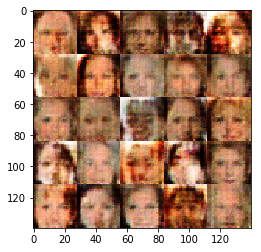

Epoch 1/1... Discriminator Loss: 1.4889... Generator Loss: 0.7082
Epoch 1/1... Discriminator Loss: 1.4945... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.4658... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 1.4878... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.5161... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.4838... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.4794... Generator Loss: 0.7406


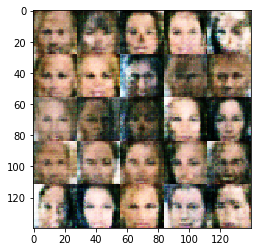

Epoch 1/1... Discriminator Loss: 1.4984... Generator Loss: 0.7482
Epoch 1/1... Discriminator Loss: 1.5456... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.5538... Generator Loss: 0.6185
Epoch 1/1... Discriminator Loss: 1.5152... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.4983... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 1.5094... Generator Loss: 0.6591
Epoch 1/1... Discriminator Loss: 1.5268... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.7024


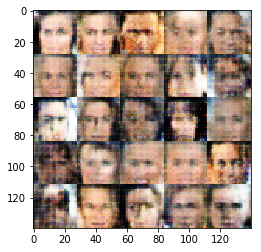

Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.4905... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 1.5017... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.7292
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.7857


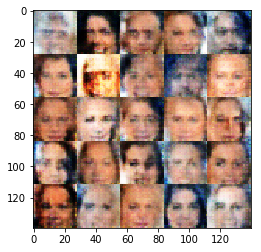

Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.5054... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 1.4922... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.4912... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.4941... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.5590... Generator Loss: 0.6122


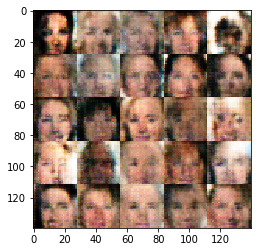

Epoch 1/1... Discriminator Loss: 1.5342... Generator Loss: 0.6554
Epoch 1/1... Discriminator Loss: 1.5095... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.5357... Generator Loss: 0.6940
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.4878... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.4969... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 0.7280


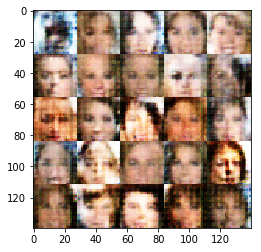

Epoch 1/1... Discriminator Loss: 1.5034... Generator Loss: 0.7067
Epoch 1/1... Discriminator Loss: 1.4761... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.4867... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 1.4992... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.4979... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 1.4880... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 1.5032... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.7060


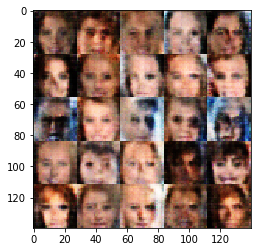

Epoch 1/1... Discriminator Loss: 1.5179... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 1.4818... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.5479... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.4958... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.7707


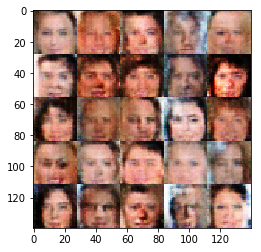

Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.7639
Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 1.5019... Generator Loss: 0.6998
Epoch 1/1... Discriminator Loss: 1.5234... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.4619... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.7193
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.7294


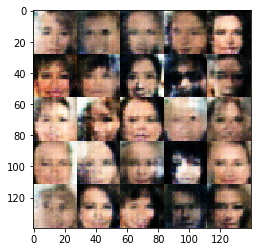

Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.7595
Epoch 1/1... Discriminator Loss: 1.5063... Generator Loss: 0.6462
Epoch 1/1... Discriminator Loss: 1.4994... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.5168... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 1.5085... Generator Loss: 0.7135
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.5121... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.7034


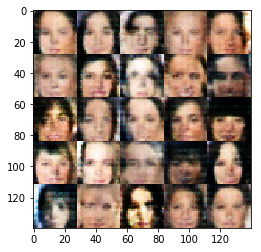

Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 1.4721... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.4416... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 1.5126... Generator Loss: 0.6639
Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.7383


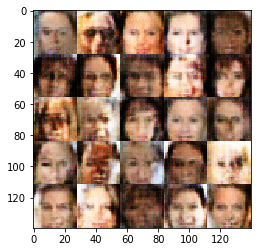

Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.7219
Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.7709


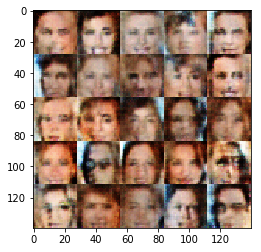

Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.4877... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.5060... Generator Loss: 0.6364
Epoch 1/1... Discriminator Loss: 1.4979... Generator Loss: 0.7204
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.7898


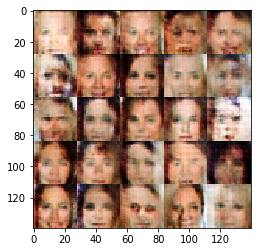

Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.7511
Epoch 1/1... Discriminator Loss: 1.4739... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.4970... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.4926... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.5241... Generator Loss: 0.6435
Epoch 1/1... Discriminator Loss: 1.5063... Generator Loss: 0.6674


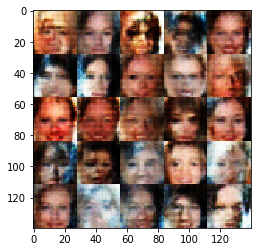

Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.7555
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.7126
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.6129... Generator Loss: 0.6219
Epoch 1/1... Discriminator Loss: 1.5391... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 1.4687... Generator Loss: 0.6975


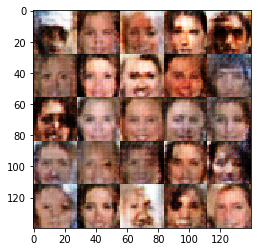

Epoch 1/1... Discriminator Loss: 1.5082... Generator Loss: 0.6175
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.5045... Generator Loss: 0.6866
Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 1.5351... Generator Loss: 0.6418
Epoch 1/1... Discriminator Loss: 1.5876... Generator Loss: 0.6179
Epoch 1/1... Discriminator Loss: 1.5853... Generator Loss: 0.6218
Epoch 1/1... Discriminator Loss: 1.5670... Generator Loss: 0.6223
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.7468


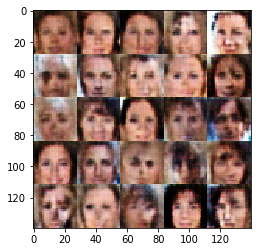

Epoch 1/1... Discriminator Loss: 1.5445... Generator Loss: 0.5886
Epoch 1/1... Discriminator Loss: 1.5691... Generator Loss: 0.6187
Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.7025
Epoch 1/1... Discriminator Loss: 1.4498... Generator Loss: 0.6765
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.7618


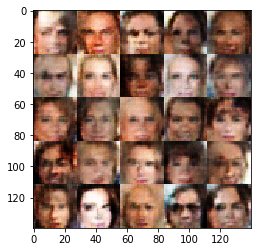

Epoch 1/1... Discriminator Loss: 1.4762... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.7185
Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.5079... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.8195
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.7316


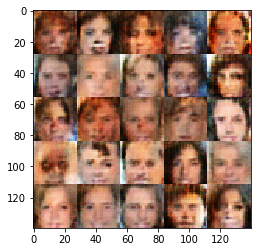

Epoch 1/1... Discriminator Loss: 1.4721... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.5461... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.4598... Generator Loss: 0.6858


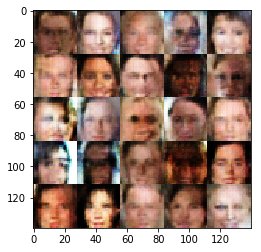

Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 1.4847... Generator Loss: 0.7036
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 1.4920... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 0.7243
Epoch 1/1... Discriminator Loss: 1.4923... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.7569


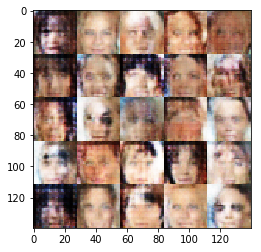

Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.7269
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.7113
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.7258


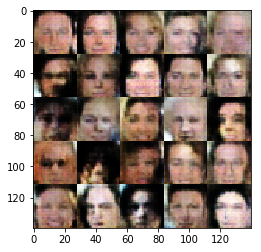

Epoch 1/1... Discriminator Loss: 1.4707... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.5005... Generator Loss: 0.6955
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.4606... Generator Loss: 0.7204
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 0.6867


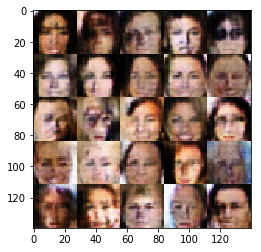

Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.6932
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.7269
Epoch 1/1... Discriminator Loss: 1.4933... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 1.4725... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.4815... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.5063... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.7831


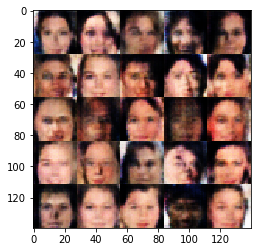

Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.4775... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.7570


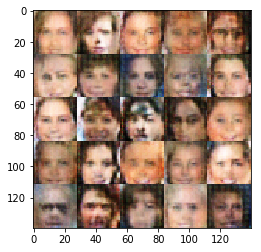

Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.5175... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.4677... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 1.4876... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.7269
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.5015... Generator Loss: 0.6907


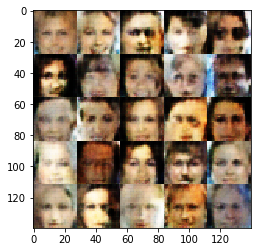

Epoch 1/1... Discriminator Loss: 1.4615... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.4912... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.4726... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.4822... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.7530
Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 0.7025
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.7529


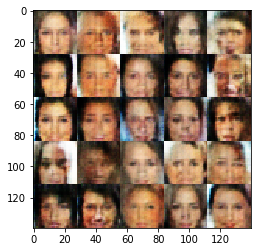

Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.6933
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.7181
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.7629
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.7498
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.7251
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.7560


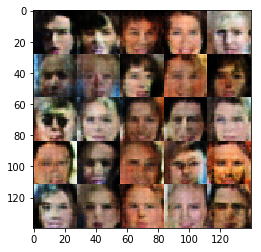

Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.4638... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.7365
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.7820


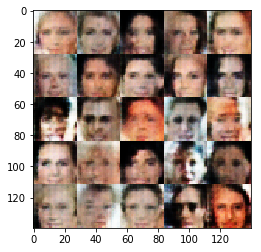

Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.7078
Epoch 1/1... Discriminator Loss: 1.4966... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.7495


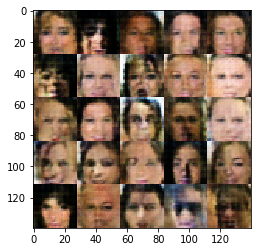

Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.4730... Generator Loss: 0.7243
Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.4770... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.5218... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.4936... Generator Loss: 0.7426


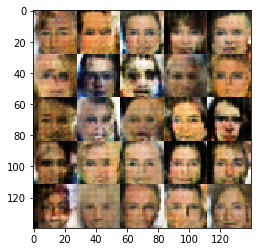

Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.8129
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.5448... Generator Loss: 0.6491
Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 0.7266


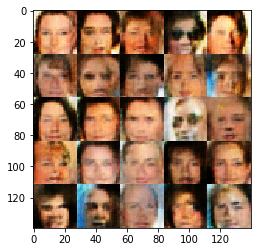

Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.4410... Generator Loss: 0.7694


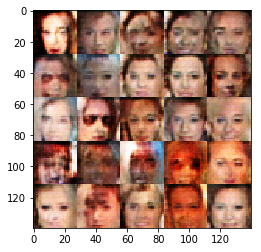

Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.4937... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.7044
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.5305... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.4792... Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.7420


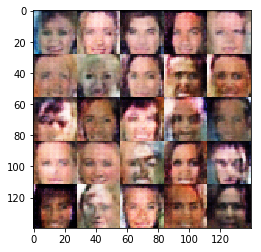

Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.4766... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.7124
Epoch 1/1... Discriminator Loss: 1.4474... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.4417... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.7726


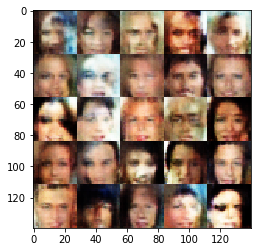

Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.7489
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.7815


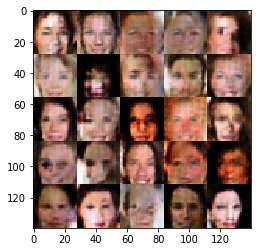

Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.8303
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.4583... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.7291


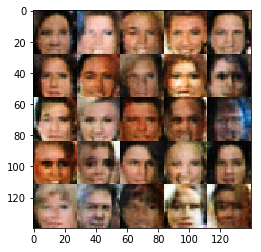

Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.4879... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.7816


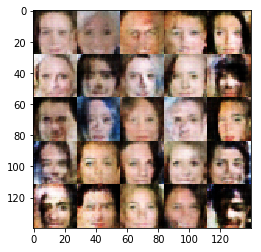

Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.4553... Generator Loss: 0.7172
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.8060
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.7662


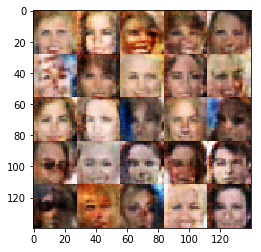

Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.4656... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.7428
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.7797
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.7248


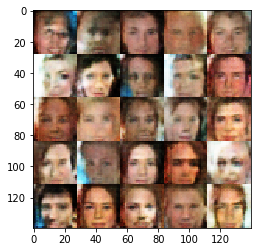

Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.7661


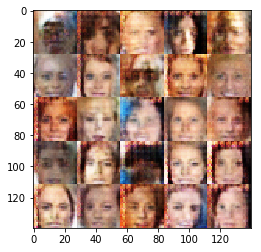

Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.7589


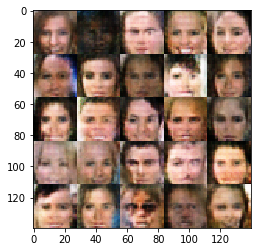

Epoch 1/1... Discriminator Loss: 1.4648... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.6953


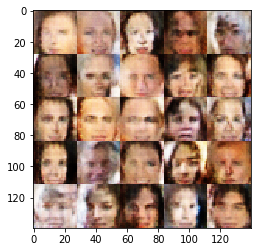

Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.7167
Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.7493


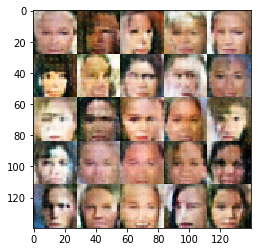

Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.7275


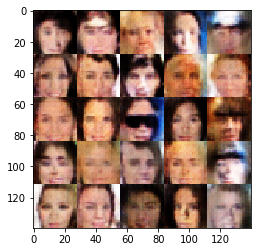

Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 1.5019... Generator Loss: 0.6556
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.7408


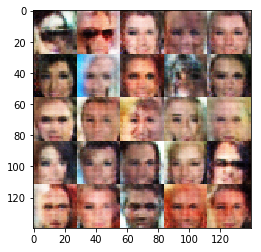

Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.4638... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.7421


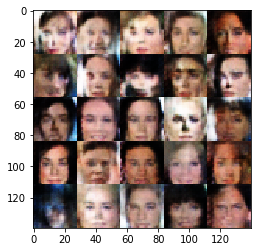

Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 1.4767... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.7511
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.7087
Epoch 1/1... Discriminator Loss: 1.4615... Generator Loss: 0.6621
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.7272


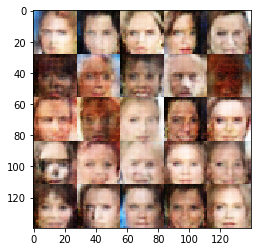

Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.4639... Generator Loss: 0.7172
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.7621


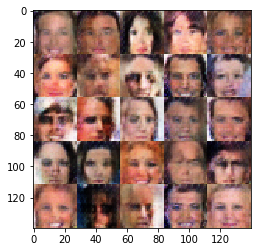

Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.7067
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.6869
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.7169
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.7321


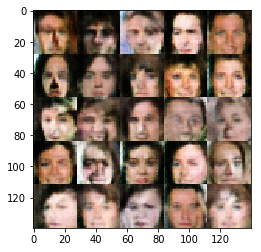

Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.7087
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.7628
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 1.4728... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.7730


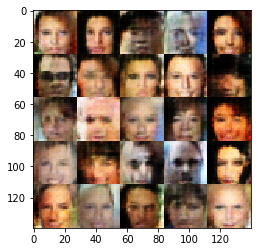

Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.8029


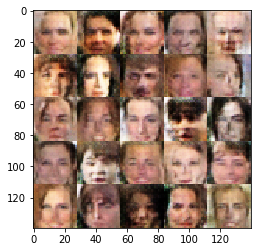

Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.7413
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.7624


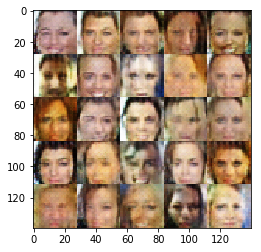

Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.7435


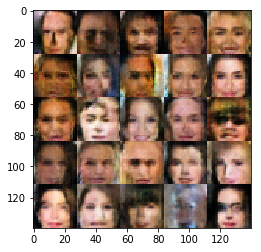

Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.7866


In [22]:
batch_size = 30
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.